# Análisis Exploratorio de Datos: EDA Dashboards

## Tabla de Contenidos

1. [Objetivo](#1-objetivo)

2. [Consideraciones](#2-consideraciones)

3. [Análisis Exploratorio de Datos](#3-análisis-exploratorio)

3.1. [Descripción del Dataset](#31-descripción-del-dataset)

3.2. [Análisis por Gerencia](#32-análisis-por-gerencia)

4. [Propuesta de Cálculo de Usabilidad](#4-propuesta-de-cálculo-de-usabilidad)

## 1. Objetivo

El objetivo de este análisis es poder definir los umbrales de uso para determinar el nivel de usabilidad de los dashboards publicados en el Centro de Servicios Compartidos de Alicorp

## 2. Consideraciones

- Para este análisis se están tomando los dashboards publicados en Power BI Viewer de las Gerencias del CSC (Administración, Tesorería Operativa y PTP, Record to Report (RTR), Excelencia Operativa, Créditos BO y Cobranzas y Gerencia de Servicios al Colaborador)
- Se está incluyendo el análisis a los dashboards publicados de la Gerencia de Operación Tributaria (Actualmente fuera del CSC)
- Se toman todas las vistas de los primeros seis (6) meses del 2025
- Se excluyen de las vistas a los usuarios del equipo de Analytics CSC (Diana Acosta, Katherine Bustamante, Angelo Perales y Juan José Palomino) debido a que han sido usuarios constructores en una gran parte de los dashboards, lo que puede distorsionar el uso real.
- Sin embargo, sí se consideran las vistas de Analytics CSC en los Dashboards publicados en el Workspace **CSC_WORK_ANALYTICS**.
- Actualmente, según el Activity Report (https://bi.alicorp.com.pe/reports/457), contamos con 59 dashboards publicados en Power BI Viewer. No obstante, el dashboard con ID 767 - **CSC - ADM - Proyectos de infraestructura** (https://bi.alicorp.com.pe/reports/767) no cuenta con vistas que no sean de usuarios que no sean de Analytics CSC, por lo que no se toma en consideración.

## 3. Análisis Exploratorio

In [86]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scorecardpy as sc
import warnings 
warnings.filterwarnings("ignore")

In [2]:
ruta_actual = os.getcwd()
ruta_archivo = os.path.join(ruta_actual,'data','dashboards_csc.xlsx')

### 3.1. Descripción del Dataset

In [4]:
df = pd.read_excel(ruta_archivo)
df.head()

,Gerencia,Dashboard,Es Activo,Descripcion,Usuario,Usuarios,Usuarios Activos,% Usuarios Activos,Promedio Mensual de Vistas,Frecuencia,...,GerenciaResponsable,nombre_workspace,ID_PowerBIViewer,enero,febrero,marzo,abril,mayo,junio,julio
0,ADM,CSC_ADM_Servicio de Taxis,1.0,Dashboard que brinda detalles del servicio y g...,NaN,338,75,0.22,26,Mensual,...,Gerencia Corporativa de Administración,CSC_ADM_Workpace,437,41.0,85.0,37.0,14.0,32.0,31,5
1,ADM,CSC_Administración,1.0,Dsashboard utilizado para realizar seguimiento...,Juan Palomino,15,7,0.47,6,Mensual,...,Gerencia Corporativa de Administración,CSC KPIs SLA Indicadores,469,11.0,4.0,12.0,1.0,3.0,3,1
2,ADM,CSC_ADM_Control presupuestal,1.0,"Alcance: Visibilidad del presupuesto, comprome...",Juan Palomino,21,11,0.52,19,Mensual,...,Gerencia Corporativa de Administración,CSC_ADM_Workpace,504,45.0,4.0,4.0,45.0,39.0,9,13
3,ADM,CSC_SLA_Administración,1.0,Dashboard indicadores procesos y Productividad,NaN,15,10,0.67,37,Mensual,...,Gerencia Corporativa de Administración,CSC KPIs SLA Indicadores,556,29.0,8.0,54.0,33.0,89.0,69,33
4,ADM,CSC_EXC_Predios,1.0,NaN,NaN,7,4,0.57,6,Mensual,...,Gerencia Corporativa de Administración,CSC_ADM_Workpace,646,7.0,1.0,2.0,3.0,1.0,16,11


In [5]:
# Tamaño del Dataset
df.shape

(58, 28)

### 3.2. Análisis por Gerencia

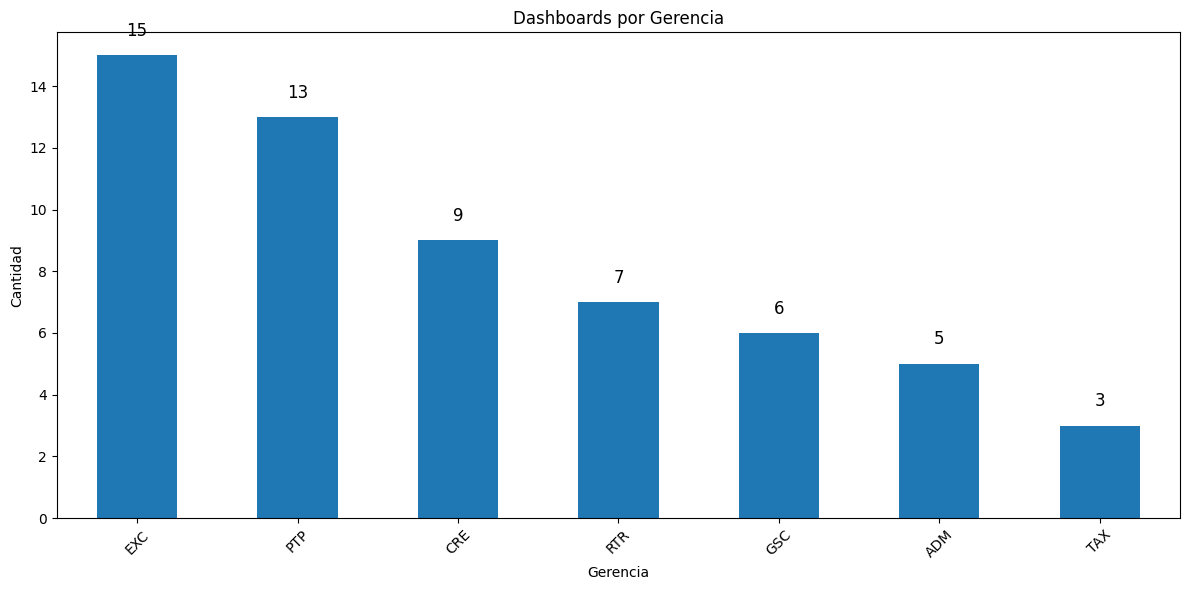

In [12]:
# Agrupar total de Dashboards por Gerencia en orden descendente
df_por_gerencia = df.groupby(['Gerencia']).size().sort_values(ascending=False)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6))

# Hacer gráfico de barras y guardar el objeto gráfico
bars = df_por_gerencia.plot(kind='bar', ax=ax)

# Añadir los números encima de cada barra
for i, value in enumerate(df_por_gerencia.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)

# Ajustes del gráfico
ax.set_title('Dashboards por Gerencia')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Gerencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.3. Vistas por Gerencia

In [14]:
meses = ['enero','febrero','marzo','abril','mayo','junio']

# Suma ignorando NaN
df['total_vistas_1_sem_2025'] = df[meses].sum(axis=1, skipna=True).round(0)

# Promedio de vistas de los primeros 6 meses del 2025. No se cuentan los valores NaN
df['prom_vistas_1_sem_2025'] = (df['total_vistas_1_sem_2025'] / df[meses].notna().sum(axis=1)).round(0)

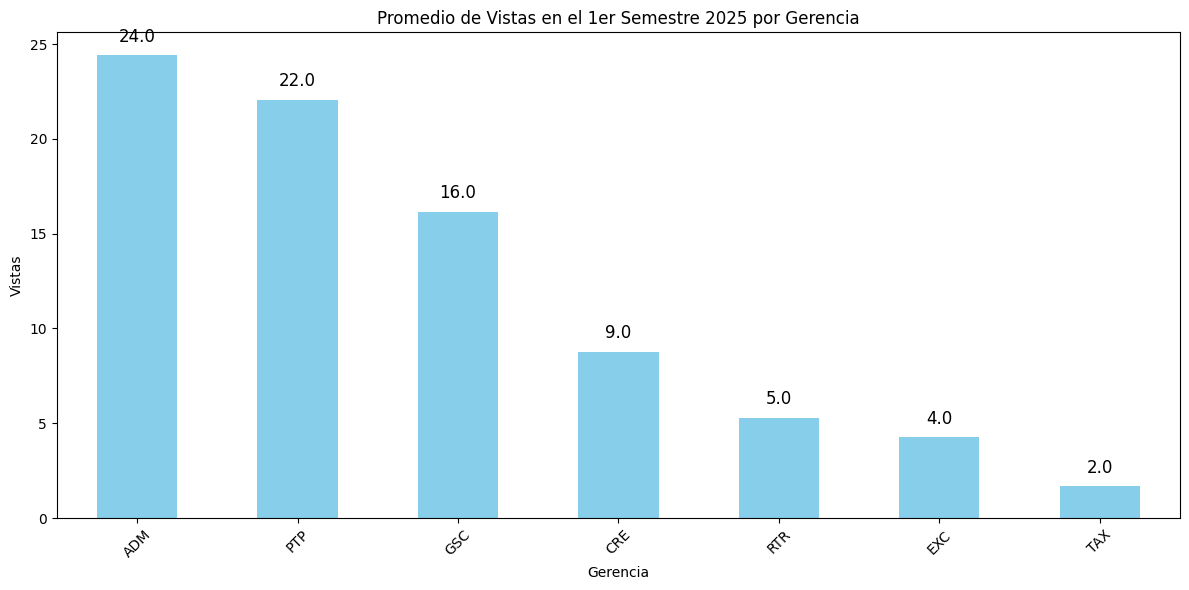

In [ ]:
# Agrupar total de Dashboards por Gerencia en orden descendente
df_por_vistas = df.groupby(['Gerencia'])['prom_vistas_1_sem_2025'].mean().sort_values(ascending=False)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6))

# Hacer gráfico de barras y guardar el objeto gráfico
bars = df_por_vistas.plot(kind='bar', ax=ax, color='skyblue')

# Añadir los números encima de cada barra
for i, value in enumerate(df_por_vistas.values):
    ax.text(i, value + 0.5, str(round(float(value),0)), ha='center', va='bottom', fontsize=12)

# Ajustes del gráfico
ax.set_title('Promedio de Vistas en el 1er Semestre 2025 por Gerencia')
ax.set_ylabel('Vistas')
ax.set_xlabel('Gerencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.4. Análisis por Frecuencia de Actualización

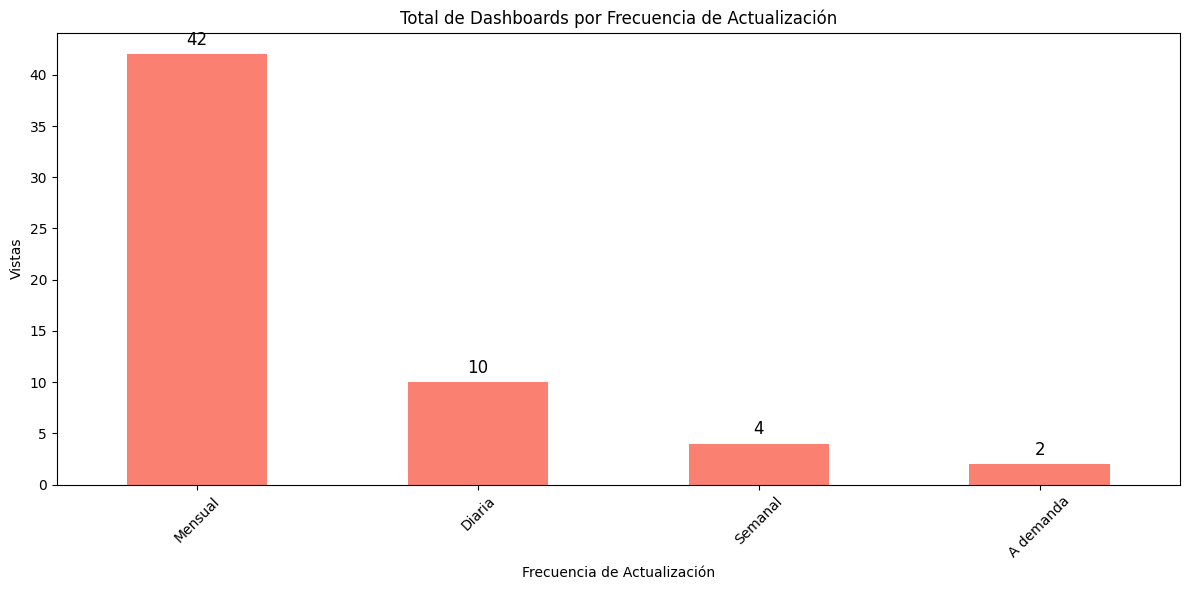

In [56]:
# Agrupar total de Dashboards por Gerencia en orden descendente
df_por_frecuencia = df.groupby(['Frecuencia']).size().sort_values(ascending=False)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6))

# Hacer gráfico de barras y guardar el objeto gráfico
bars = df_por_frecuencia.plot(kind='bar', ax=ax, color='salmon')

# Añadir los números encima de cada barra
for i, value in enumerate(df_por_frecuencia.values):
    ax.text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontsize=12)

# Ajustes del gráfico
ax.set_title('Total de Dashboards por Frecuencia de Actualización')
ax.set_ylabel('Vistas')
ax.set_xlabel('Frecuencia de Actualización')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Vistas por Frecuencia de Actualización

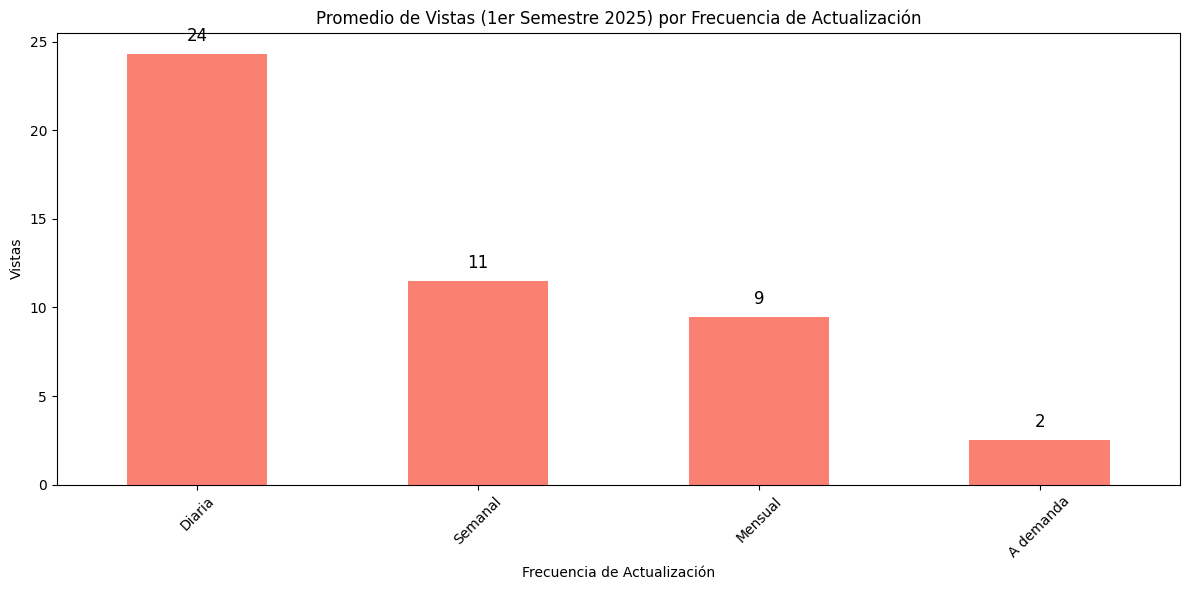

In [55]:
# Agrupar total de Dashboards por Gerencia en orden descendente
df_vistas_por_frecuencia = df.groupby(['Frecuencia'])['prom_vistas_1_sem_2025'].mean().sort_values(ascending=False)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6))

# Hacer gráfico de barras y guardar el objeto gráfico
bars = df_vistas_por_frecuencia.plot(kind='bar', ax=ax, color='salmon')

# Añadir los números encima de cada barra
for i, value in enumerate(df_vistas_por_frecuencia.values):
    ax.text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontsize=12)

# Ajustes del gráfico
ax.set_title('Promedio de Vistas (1er Semestre 2025) por Frecuencia de Actualización')
ax.set_ylabel('Vistas')
ax.set_xlabel('Frecuencia de Actualización')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En esta gráfica podemos notar que:
- Los Dashboards diarios tienen el mayor promedio de visualizaciones. Esto se puede explicar debido a que, a un mayor ritmo de actualización, los usuarios están al más al tanto de las actualizaciones.
- Por otro lado, los dashboards a demanda son los menos vistos (2 vistas en promedio en 6 meses). Esto se puede explicar a que la responsabilidad de actualización depende enteramente de la Gerencia.

### 3.5. Análisis de Vistas

In [24]:
total_vistas = df['prom_vistas_1_sem_2025']
total_vistas[:5]

0    40.0
1     6.0
2    24.0
3    47.0
4     5.0
Name: prom_vistas_1_sem_2025, dtype: float64

In [26]:
# Ver la mediana de vistas
mediana_vistas = np.median(total_vistas)

print('Mediana del Promedio de Vistas 2025:',mediana_vistas)

Mediana del Promedio de Vistas 2025: 4.5


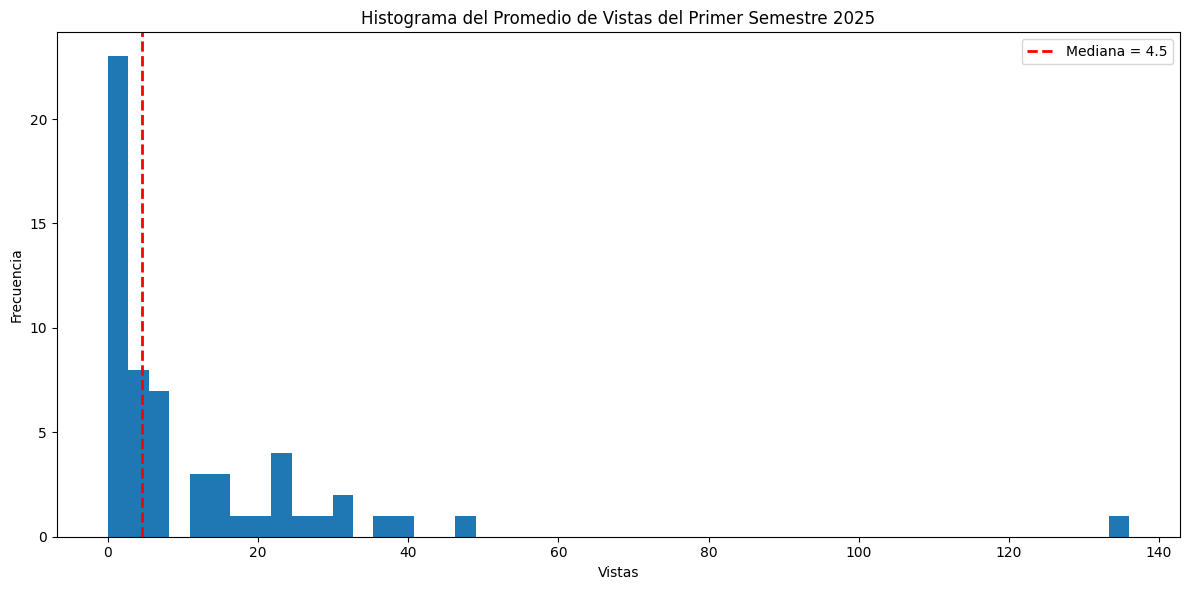

In [31]:
plt.figure(figsize=(12,6))
plt.hist(total_vistas,bins=50)

# Añadir mediana
plt.axvline(x=mediana_vistas,color='red',linestyle='--',linewidth=2,label=f'Mediana = {mediana_vistas:.1f}')

# Estética
plt.title('Histograma del Promedio de Vistas del Primer Semestre 2025')
plt.xlabel('Vistas')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
total_dashboards_debajo_mediana = len(total_vistas[total_vistas>mediana_vistas])

print('Total de Dashboards por debajo de la Mediana:',total_dashboards_debajo_mediana)
print('% de Dashboards por debajo de la Mediana:',total_dashboards_debajo_mediana/len(total_vistas))

Total de Dashboards por debajo de la Mediana: 29
% de Dashboards por debajo de la Mediana: 0.5


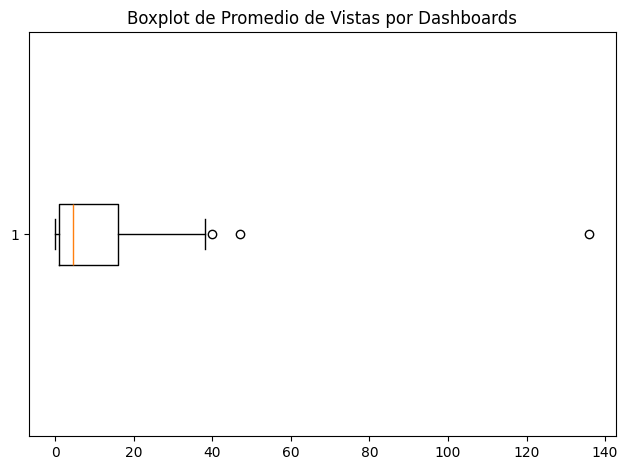

In [42]:
plt.boxplot(total_vistas,vert=False)
plt.title('Boxplot de Promedio de Vistas por Dashboards')
plt.tight_layout()
plt.show()

In [45]:
# Selección de 1er y 3er cuartil
Q1 = total_vistas.quantile(0.25)
Q3 = total_vistas.quantile(0.75)

# Rango Intercuartil
IQR = Q3 - Q1

# Definir whiskers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

print('IQR:',IQR)
print('Lower Whisker:',lower_whisker)
print('Upper Whisker:',upper_whisker)

# Calcular valores Outliers
outliers = total_vistas[(total_vistas<lower_whisker) | (total_vistas>upper_whisker)]

# Identificar Dashboards con número de vistas atípicas
print(df[['Dashboard','prom_vistas_1_sem_2025']][df['prom_vistas_1_sem_2025'].isin(outliers)].sort_values(by='prom_vistas_1_sem_2025',ascending=False))

IQR: 15.0
Lower Whisker: -21.5
Upper Whisker: 38.5
                               Dashboard  prom_vistas_1_sem_2025
44  CSC_PTP Gestión del Proceso OC-OS TI                   136.0
3                 CSC_SLA_Administración                    47.0
0              CSC_ADM_Servicio de Taxis                    40.0


### 4. Propuesta de Cálculo de Usabilidad

$$
{\text{Umbral de Usabilidad}} = {\text{Total de Usuarios con Acceso}} \times {\text{Factor de Frecuencia}} \times 0.10
$$ 

Donde:
- ${\text{Total de Usuarios con Acceso}}$: Es el número de usuarios que tienen acceso de visualización al Dashboard publicado en Power BI Viewer

- ${\text{Factor de Frecuencia}}$: Es un coeficiente que va a variar en función a la frecuencia de actualización del Dashboard. Este factor nos ayuda a comparar las distintas frecuencias de manera uniforme. 

- $0.10$: Es una constante que nos ayuda a definir un umbral como un porcentaje del número de vistas.


In [57]:
df['Frecuencia'].unique()

array(['Mensual', 'Semanal', 'Diaria', 'A demanda'], dtype=object)

In [58]:
1/12

0.08333333333333333

In [87]:
dict_frecuencia = {
    'Mensual': 1,
    'Semanal': 4, # 4 semanas en un mes
    'A demanda': 1, # Se va a calcular como mensual
    'Diaria': 22, # Solo se van a contar días hábiles
    'Semestral': 0.5, # 1/6
    'Trimestral': 0.33, # 1/3
    'Anual': 0.08 # 1/12
}

def umbral_usabilidad(total_usuarios,frecuencia,coef=0.10):

    """
    Función para determinar el umbral de usabilidad por dashboards.
    Args:
    - Total Usuarios
    - Frecuencia de Actualización
    - Coeficiente
    """

    # Calcular para definir el total de vistas de los últimos 6 meses
    factor_frecuencia = dict_frecuencia[frecuencia] * 6

    return round(math.ceil(coef * total_usuarios) * factor_frecuencia,0)


In [88]:
# Aplicar función de umbral de vistas
df['umbral_vistas'] = df.apply(lambda row: umbral_usabilidad(total_usuarios=row['Usuarios'],
                                                             frecuencia=row['Frecuencia']),
                                                             axis=1)

# Añadir flag de "es activo" siempre y cuando el total de vistas sea mayor o igual al umbral seleccionado
df['es_activo'] = np.where(df['total_vistas_1_sem_2025'] >= df['umbral_vistas'],1,0)

df[['Dashboard','Usuarios','Frecuencia','total_vistas_1_sem_2025','umbral_vistas','es_activo']].sort_values('total_vistas_1_sem_2025',ascending=False).head(25)

,Dashboard,Usuarios,Frecuencia,total_vistas_1_sem_2025,umbral_vistas,es_activo
44,CSC_PTP Gestión del Proceso OC-OS TI,141,Diaria,815.0,1980,0
3,CSC_SLA_Administración,15,Mensual,282.0,12,1
0,CSC_ADM_Servicio de Taxis,338,Mensual,240.0,204,1
45,CSC_PTP Control de Liquidación de Transportes,39,Mensual,227.0,24,1
31,CSC_SLA_Servicios al Colaborador,39,Mensual,185.0,24,1
32,CSC_SLA_Servicios al Colaborador v4 (Vacaciones),49,Diaria,178.0,660,0
43,CSC_PTP Gestión de Creación de OC-OS - TI,113,Mensual,174.0,72,1
51,CSC_SLA_RTR,52,Mensual,147.0,36,1
2,CSC_ADM_Control presupuestal,21,Mensual,146.0,18,1
7,CSC_TES_Saldos a favor,136,Semanal,131.0,336,0


In [1]:
141 * 0.05 * 22

umbral_usabilidad(total_usuarios=141,frecuencia='Diaria',coef=0.1)

NameError: name 'umbral_usabilidad' is not defined